## HW 4

### Описание
В скором времени AI агенты достигнут уровня развития человека. А значит им придется столкнуться с проблемами, которые раньше были свойственны только людям.
Им придется сдавать ЕГЭ. Поэтому мы решили заранее помочь им подготовиться к экзамену по литературе.
Агент прочитал романы Война и Мир Толстого и Преступление и наказание Достоевского, но мало что запомнил. Поможем ему понять эти романы лучше.
Для этого мы научим его определять по вырванной цитате из романа, к какому роману она относится.

### Данные
train.csv - обучающая выборка, содержит 2 поля:
* text - текст цитаты
* label - метка класса (0 - Война и Мир, 1 - Преступление и наказание)

mlm.txt - plain текст вперемешку цитат из обоих романов.

### Задача
1. **Обучить классификатор** (фактически та же задача, что и на практике 5):
* Разбить train.csv на train и valid выборки
* Обучить модель, которая по тексту цитаты будет определять к какому роману она относится. Необходимо использовать модель "distilbert/distilroberta-base" из huggingface.
* Протестировать на valid: confusion_matrix, accuracy, f1. Сохранить эти метрики.
2. **Претренировать модель с помощью unsupervised masked language modeling** на train-test.txt
* Воспользоваться вот этим туториалом https://huggingface.co/docs/transformers/main/tasks/masked_language_modeling
* Вывести метрики perplexity и loss до и после обучения
3. **Перетренировать классификатор из пункта 1**, но использовать претренированные веса из пункта 2
* сравнить метрики с пунктом 1

### Требования к решению
* Ноутбук с кодом и метриками
* submission.csv на основе test.csv с предсказаниями залитый на платформу контестов
* accuracy на test: 0.56 и меньше - 0 баллов, 0.75 и больше - 10 баллов

### Подсказки
* Вероятно ваши метрики на валидации (как до MLM так и после) получились сильно выше, чем на test
* Текст в test обрабатывался чуть иначе, чем в train
* Надо понять в чем причина, исправить. Ваши метрики на val станут ниже, зато на test повысятся.













# Обучить классификатор

In [ ]:
!pip uninstall -y transformers tokenizers
!pip install transformers --no-build-isolation

Found existing installation: transformers 4.57.1
Uninstalling transformers-4.57.1:
  Successfully uninstalled transformers-4.57.1
Found existing installation: tokenizers 0.22.1
Uninstalling tokenizers-0.22.1:
  Successfully uninstalled tokenizers-0.22.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 79.0 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from tqdm.auto import tqdm, trange
import pandas as pd
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    AutoModelForMaskedLM, DataCollatorForLanguageModeling,
    TrainingArguments, Trainer, pipeline
)
import torch
import numpy as np
from datasets import Dataset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import math
import os

In [ ]:
data = pd.read_csv('train-2.csv')

data.head()

,text,label
0,— Кровь! какую кровь? — встревожилась,1
1,– Под нижнюю подушку.,0
2,— Благодарю-с...,1
3,— Когда же это-с?,1
4,"Старуха помолчала, как бы в раздумье,",1


<Axes: xlabel='label'>

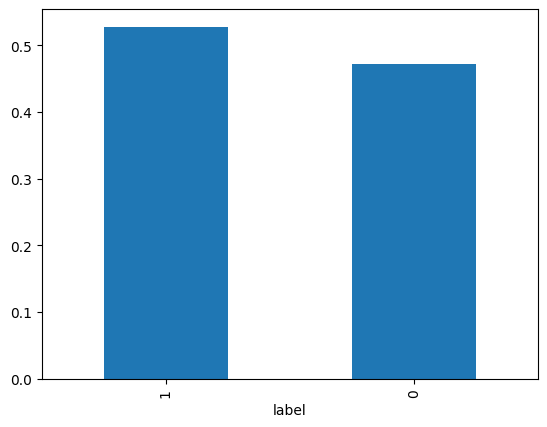

In [ ]:
data['label'].value_counts(normalize = True).plot.bar()

In [ ]:
model_name = "distilbert/distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    data['text'], data['label'], test_size=0.33, random_state=42
)

tokenized_train = tokenizer(list(X_train), padding='max_length', truncation=True, max_length=128)
tokenized_val = tokenizer(list(X_val), padding='max_length', truncation=True, max_length=128)

In [ ]:
train_dataset = Dataset.from_dict({
    'input_ids': tokenized_train['input_ids'],
    'attention_mask': tokenized_train['attention_mask'],
    'labels': y_train
})

val_dataset = Dataset.from_dict({
    'input_ids': tokenized_val['input_ids'],
    'attention_mask': tokenized_val['attention_mask'],
    'labels': y_val
})

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
).to(device)

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
os.environ["WANDB_DISABLED"] = "true"

training_args = TrainingArguments(
    output_dir='./classifier_results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {
        # 'confusion_matrix': confusion_matrix(labels, predictions),
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions, average='weighted')
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)


trainer.train()

base_metrics = trainer.evaluate()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-2517015799.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.255800,0.227317,0.879162,0.879245
2,0.218800,0.273421,0.878088,0.877756
3,0.206000,0.210752,0.893663,0.893736


In [ ]:
trainer.predict(val_dataset)

PredictionOutput(predictions=array([[-2.5666159e-01,  2.8827602e-01],
       [-2.8116688e-02,  7.5473942e-02],
       [-4.2387261e+00,  4.3140111e+00],
       ...,
       [-3.4881756e+00,  3.4408822e+00],
       [-1.7702036e-03,  5.4932240e-02],
       [ 1.1028725e+00, -1.1770202e+00]], dtype=float32), label_ids=array([1, 0, 1, ..., 1, 1, 1]), metrics={'test_loss': 0.21075214445590973, 'test_accuracy': 0.8936627282491945, 'test_f1': 0.8937364148606142, 'test_runtime': 6.6696, 'test_samples_per_second': 279.179, 'test_steps_per_second': 17.542})

In [ ]:
predictions = trainer.predict(val_dataset)
labels = predictions.label_ids
predictions = np.argmax(predictions.predictions, axis=1)
cm = confusion_matrix(labels, predictions)
cm

array([[802,  79],
       [119, 862]])

In [ ]:
base_metrics

{'eval_loss': 0.21075214445590973,
 'eval_accuracy': 0.8936627282491945,
 'eval_f1': 0.8937364148606142,
 'eval_runtime': 6.8287,
 'eval_samples_per_second': 272.672,
 'eval_steps_per_second': 17.134,
 'epoch': 3.0}

In [ ]:
print(f"Perplexity: {math.exp(base_metrics['eval_loss']):.2f}")

Perplexity: 1.23


In [ ]:
metrics_without_mlm = {
    'accuracy': base_metrics['eval_accuracy'],
    'f1': base_metrics['eval_f1'],
    'confusion_matrix': cm
}
metrics_without_mlm

{'accuracy': 0.8936627282491945,
 'f1': 0.8937364148606142,
 'confusion_matrix': array([[802,  79],
        [119, 862]])}

In [ ]:
pd.DataFrame([metrics_without_mlm]).to_csv('metrics_without_mlm.csv', index=False)

In [ ]:
trainer.save_model('model_without_mlm')

In [ ]:
base_metrics

{'eval_loss': 0.21075214445590973,
 'eval_accuracy': 0.8936627282491945,
 'eval_f1': 0.8937364148606142,
 'eval_runtime': 6.8287,
 'eval_samples_per_second': 272.672,
 'eval_steps_per_second': 17.134,
 'epoch': 3.0}

In [ ]:
!zip -r model_without_mlm.zip model_without_mlm

  adding: model_without_mlm/ (stored 0%)
  adding: model_without_mlm/vocab.json (deflated 59%)
  adding: model_without_mlm/tokenizer.json (deflated 82%)
  adding: model_without_mlm/merges.txt (deflated 53%)
  adding: model_without_mlm/special_tokens_map.json (deflated 52%)
  adding: model_without_mlm/model.safetensors (deflated 7%)
  adding: model_without_mlm/training_args.bin (deflated 53%)
  adding: model_without_mlm/tokenizer_config.json (deflated 75%)
  adding: model_without_mlm/config.json (deflated 50%)


In [ ]:
from google.colab import files
files.download("model_without_mlm.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Претренировать модель с помощью unsupervised masked language modeling

In [ ]:
train_test_txt = open('mlm.txt').read().splitlines()
len(train_test_txt)

1

In [ ]:
import re
mlm_sentences = []
sentences = re.split(r'[.!?]', train_test_txt[0])
for sentence in sentences:
    if sentence.strip():
        mlm_sentences.append(sentence)

In [ ]:
mlm_sentences[:10]

['- Кровь',
 ' какую кровь',
 ' - встревожилась Пульхерия Александровна',
 ' - Под нижнюю подушку',
 ' - Благодарю-с',
 ' - Когда же это-с',
 ' Старуха помолчала, как бы в раздумье, потом отступила в сторону и, указывая на дверь в комнату, произнесла, пропуская гостя вперед: Он поднял глаза, вдумчиво посмотрел на всех, улыбнулся и взял фуражку',
 ' Он был слишком спокоен сравнительно с тем, как вошел давеча, и чувствовал это',
 ' Все встали',
 ' [Ну, княжна, еще маленькое усилие']

In [ ]:
len(mlm_sentences)

31093

In [ ]:
mlm_dataset = Dataset.from_dict({"text": mlm_sentences})
mlm_dataset

Dataset({
    features: ['text'],
    num_rows: 31093
})

In [ ]:
mlm_dataset = Dataset.from_dict({"text": mlm_sentences})
mlm_dataset = mlm_dataset.map(lambda x: tokenizer(x['text'], padding='max_length', truncation=True, max_length=128), batched=True)

Map:   0%|          | 0/31093 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

mlm_model = AutoModelForMaskedLM.from_pretrained(model_name)
eval_pipeline = pipeline('fill-mask', model=mlm_model, tokenizer=tokenizer)

Some weights of the model checkpoint at distilbert/distilroberta-base were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


In [ ]:
mlm_training_args_eval = TrainingArguments(
    output_dir="mlm_eval",
    per_device_eval_batch_size=16,
    do_train=False,
    do_eval=True,
)

mlm_trainer_before = Trainer(
    model=mlm_model,
    args=mlm_training_args_eval,
    data_collator=data_collator,
    eval_dataset=mlm_dataset,
)

eval_before = mlm_trainer_before.evaluate()
eval_before

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'eval_loss': 1.4260236024856567,
 'eval_model_preparation_time': 0.0014,
 'eval_runtime': 205.0928,
 'eval_samples_per_second': 151.605,
 'eval_steps_per_second': 9.479}

In [ ]:
print(f"Perplexity before: {math.exp(eval_before['eval_loss']):.2f}")

Perplexity before: 4.16


In [ ]:
training_args = TrainingArguments(
    output_dir="mlm_eval",
    overwrite_output_dir=True,
    per_device_train_batch_size=16,
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=mlm_model,
    args=training_args,
    train_dataset=mlm_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-30698788.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,1.262800
1000,1.131000
1500,1.059900
2000,1.009000
2500,0.958600
3000,0.929100
3500,0.905200
4000,0.880600
4500,0.869500
5000,0.858400


TrainOutput(global_step=5832, training_loss=0.9664582774472334, metrics={'train_runtime': 1967.2311, 'train_samples_per_second': 47.416, 'train_steps_per_second': 2.965, 'total_flos': 3092707374273792.0, 'train_loss': 0.9664582774472334, 'epoch': 3.0})

In [ ]:
# TrainOutput(global_step=5832, training_loss=0.9664582774472334, metrics={'train_runtime': 1967.2311, 'train_samples_per_second': 47.416, 'train_steps_per_second': 2.965, 'total_flos': 3092707374273792.0, 'train_loss': 0.9664582774472334, 'epoch': 3.0})
train_loss = 0.9664582774472334
print(f"Perplexity after: {math.exp(train_loss):.2f}")

Perplexity after: 2.63


In [ ]:
trainer.save_model("mlm_finetuned")

In [ ]:
!zip -r mlm_finetuned.zip mlm_finetuned

  adding: mlm_finetuned/ (stored 0%)
  adding: mlm_finetuned/vocab.json (deflated 59%)
  adding: mlm_finetuned/tokenizer.json (deflated 82%)
  adding: mlm_finetuned/merges.txt (deflated 53%)
  adding: mlm_finetuned/special_tokens_map.json (deflated 52%)
  adding: mlm_finetuned/model.safetensors (deflated 7%)
  adding: mlm_finetuned/training_args.bin (deflated 53%)
  adding: mlm_finetuned/tokenizer_config.json (deflated 75%)
  adding: mlm_finetuned/config.json (deflated 49%)


In [ ]:
from google.colab import files
files.download("mlm_finetuned.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Перетренировать классификатор из пункта 1

In [ ]:
model_with_mlm = AutoModelForSequenceClassification.from_pretrained("mlm_finetuned", num_labels=2)

training_args = TrainingArguments(
    output_dir='./classifier_results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {
        # 'confusion_matrix': confusion_matrix(labels, predictions),
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions, average='weighted')
    }


trainer_with_mlm = Trainer(
    model=model_with_mlm,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)


trainer_with_mlm.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at mlm_finetuned and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.282100,0.217354,0.875403,0.875317
2,0.206900,0.171400,0.907626,0.907682
3,0.175500,0.161657,0.918904,0.918858


TrainOutput(global_step=711, training_loss=0.27800177438014334, metrics={'train_runtime': 183.3387, 'train_samples_per_second': 61.82, 'train_steps_per_second': 3.878, 'total_flos': 375346374091776.0, 'train_loss': 0.27800177438014334, 'epoch': 3.0})

In [ ]:
trainer_with_mlm.evaluate()

{'eval_loss': 0.16165712475776672,
 'eval_accuracy': 0.9189044038668098,
 'eval_f1': 0.9188576959144827,
 'eval_runtime': 6.1911,
 'eval_samples_per_second': 300.754,
 'eval_steps_per_second': 18.898,
 'epoch': 3.0}

In [ ]:
trainer_with_mlm.save_model("model_with_mlm")

In [ ]:
!zip -r model_with_mlm.zip model_with_mlm

  adding: model_with_mlm/ (stored 0%)
  adding: model_with_mlm/model.safetensors (deflated 7%)
  adding: model_with_mlm/training_args.bin (deflated 53%)
  adding: model_with_mlm/config.json (deflated 50%)


In [ ]:
from google.colab import files
files.download("model_with_mlm.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test = pd.read_csv('submission.csv')

In [ ]:
test

,text,label
0,"Он говорил ему, указывая на поля,",-1
1,"Тревога беспредметная и бесцельная в настоящем,",-1
2,"- Я о тебе, третьего дня",-1
3,- Что ж вы? - закричал,-1
4,Он с мучением задавал себе этот,-1
...,...,...
1435,"- Ах, Боже мой, граф, есть",-1
1436,"- Ну Денисов другое дело, -",-1
1437,"- А помнишь, как мы катали",-1
1438,- Я ключ потерял и не,-1


In [ ]:
test_dataset = Dataset.from_dict({"text": test['text']})
test_dataset

Dataset({
    features: ['text'],
    num_rows: 1440
})

In [ ]:
test_dataset = test_dataset.map(lambda x: tokenizer(x['text'], padding='max_length', truncation=True, max_length=128), batched=True)

Map:   0%|          | 0/1440 [00:00<?, ? examples/s]

In [ ]:
predictions_after = trainer_with_mlm.predict(test_dataset)


In [ ]:
predictions_after

PredictionOutput(predictions=array([[-0.41872442,  0.4145106 ],
       [ 0.45447984, -0.47851717],
       [-3.8704846 ,  4.1222253 ],
       ...,
       [-3.8234339 ,  4.106821  ],
       [-3.860122  ,  4.1187935 ],
       [ 2.3278213 , -2.3273118 ]], dtype=float32), label_ids=None, metrics={'test_runtime': 4.9914, 'test_samples_per_second': 288.495, 'test_steps_per_second': 18.031})

In [ ]:
predictions_after.predictions

array([[-0.41872442,  0.4145106 ],
       [ 0.45447984, -0.47851717],
       [-3.8704846 ,  4.1222253 ],
       ...,
       [-3.8234339 ,  4.106821  ],
       [-3.860122  ,  4.1187935 ],
       [ 2.3278213 , -2.3273118 ]], dtype=float32)

In [ ]:
predictions = np.argmax(predictions_after.predictions, axis=1)

In [ ]:
predictions

array([1, 0, 1, ..., 1, 1, 0])

In [ ]:
len(predictions)

1440

In [ ]:
test.label = predictions

In [ ]:
test.to_csv('my_subm.csv')